In [125]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GATConv

import numpy as np
import scipy.io as sio
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [126]:
data_mat = sio.loadmat('Indian_pines_corrected.mat')
labels_mat = sio.loadmat('Indian_pines_gt.mat')
data = data_mat['indian_pines_corrected']
labels = labels_mat['indian_pines_gt']  #一共十六个类别,0-16,0代表背景,应该去除

# 数据形状
print('Data shape:', data.shape)
print('Labels shape:', labels.shape)

Data shape: (145, 145, 200)
Labels shape: (145, 145)


In [127]:
# 重塑数据
height, width, bands = data.shape
data_reshaped = data.reshape(-1, bands)
labels_reshaped = labels.reshape(-1)


# 数据标准化
scaler = StandardScaler()
data_reshaped = scaler.fit_transform(data_reshaped)

# 去除为0的标签（未标记的像素）
masked_data = data_reshaped[labels_reshaped > 0]
print('Masked data shape:', masked_data.shape)
masked_labels = labels_reshaped[labels_reshaped > 0] - 1  # 标签从0开始
print('Masked labels shape:', masked_labels.shape)
# 查看类别数量
num_classes = np.max(masked_labels) + 1
print('Number of classes:', num_classes)

Masked data shape: (10249, 200)
Masked labels shape: (10249,)
Number of classes: 16


In [128]:
class HSI_Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data).float()
        self.labels = torch.from_numpy(labels).long()
        self.indices = np.arange(len(self.labels))
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # 将光谱数据视为“图像”的通道
        sample = self.data[idx]
        sample = sample.unsqueeze(1).unsqueeze(2)  # shape: [bands, 1, 1]
        label = self.labels[idx]
        index = self.indices[idx]  # 获取样本索引
        return sample, label, index

# 划分训练和测试集
train_data, test_data, train_labels, test_labels = train_test_split(
    masked_data, masked_labels, test_size=0.98, random_state=42, stratify=masked_labels)  #每种类别的比例保持一致

# 创建数据集
train_dataset = HSI_Dataset(train_data, train_labels)
test_dataset = HSI_Dataset(test_data, test_labels)

# 创建数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [129]:
# CNN编码器，用于提取光谱特征
class CNNEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x形状: [batch_size, in_channels, height, width]
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # 展平
        return x  # 返回形状: [batch_size, out_channels]

# GAT编码器，用于捕获空间关系
class GATEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, heads=8):
        super(GATEncoder, self).__init__()
        self.gat1 = GATConv(in_channels, 64, heads=heads, concat=True)
        self.gat2 = GATConv(64 * heads, out_channels, heads=1, concat=False)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        # x形状: [num_nodes, in_channels]
        x = self.relu(self.gat1(x, edge_index))
        x = self.relu(self.gat2(x, edge_index))
        return x  # 返回形状: [num_nodes, out_channels]

# 加权特征融合模型
class WeightedFeatureFusion(nn.Module):
    def __init__(self, cnn_in_channels, gat_in_channels, num_classes):
        super(WeightedFeatureFusion, self).__init__()
        self.cnn_encoder = CNNEncoder(cnn_in_channels, 128)
        self.gat_encoder = GATEncoder(gat_in_channels, 128)
        self.cnn_weight = nn.Parameter(torch.tensor(0.5))
        self.gat_weight = nn.Parameter(torch.tensor(0.5))
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, cnn_x, data):
        # cnn_x 形状：[num_nodes, in_channels, 1, 1]
        cnn_feat = self.cnn_encoder(cnn_x)  # 形状：[num_nodes, 128]
        gat_feat = self.gat_encoder(data.x, data.edge_index)  # 形状：[num_nodes, 128]

        # 融合特征
        fused_feat = self.cnn_weight * cnn_feat + self.gat_weight * gat_feat
        out = self.classifier(fused_feat)  # 形状：[num_nodes, num_classes]
        return out

In [130]:
device = torch.device('cpu')

model = WeightedFeatureFusion(cnn_in_channels=bands, gat_in_channels=bands, num_classes=num_classes)
model=model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [131]:
# 创建图数据
from torch_geometric.utils import grid

# 获取图的边索引
edge_index = grid(height, width)[0]

# 所有节点的特征
node_features = torch.from_numpy(data_reshaped).float()  # 形状：[num_nodes, feature_dim]

# 节点标签（包括未标记的节点）
#labels_reshaped = labels_reshaped.astype(np.int32)
labels_reshaped[labels_reshaped == 0] = 255
labels_reshaped[labels_reshaped != 255] -= 1
all_labels = torch.from_numpy(labels_reshaped).long()  # 减 1 是让标签从 0 开始
print('All labels:', all_labels)
# 创建图数据对象
graph_data = Data(x=node_features.to(device), edge_index=edge_index.to(device))

# 划分训练集和测试集
labeled_indices = torch.where(all_labels != 255)[0]

train_indices, test_indices = train_test_split(
    labeled_indices.cpu().numpy(),
    test_size=0.98,
    random_state=42,
    stratify=all_labels[labeled_indices].cpu()
)

train_mask = torch.zeros(all_labels.size(0), dtype=torch.bool)
test_mask = torch.zeros(all_labels.size(0), dtype=torch.bool)
train_mask[train_indices] = True
test_mask[test_indices] = True

masked_labels = all_labels  # 包含未标记的节点，值为 -1

All labels: tensor([  2,   2,   2,  ..., 255, 255, 255])


In [132]:
unique_labels = np.unique(masked_labels.cpu().numpy())
#print("Unique labels:", unique_labels[16])

Epoch [1/100], Loss: 2.7172
Test Accuracy: 36.36%
Epoch [2/100], Loss: 2.4372
Test Accuracy: 36.49%
Epoch [3/100], Loss: 2.2133
Test Accuracy: 36.33%
Epoch [4/100], Loss: 2.0350
Test Accuracy: 36.30%
Epoch [5/100], Loss: 1.9099
Test Accuracy: 36.39%
Epoch [6/100], Loss: 1.8262
Test Accuracy: 38.94%
Epoch [7/100], Loss: 1.7594
Test Accuracy: 40.68%
Epoch [8/100], Loss: 1.7050
Test Accuracy: 41.23%
Epoch [9/100], Loss: 1.6639
Test Accuracy: 41.71%
Epoch [10/100], Loss: 1.6175
Test Accuracy: 42.20%
Epoch [11/100], Loss: 1.5672
Test Accuracy: 43.57%
Epoch [12/100], Loss: 1.5288
Test Accuracy: 45.80%
Epoch [13/100], Loss: 1.5015
Test Accuracy: 46.90%
Epoch [14/100], Loss: 1.4693
Test Accuracy: 48.47%
Epoch [15/100], Loss: 1.4264
Test Accuracy: 49.16%
Epoch [16/100], Loss: 1.3835
Test Accuracy: 49.53%
Epoch [17/100], Loss: 1.3516
Test Accuracy: 49.36%
Epoch [18/100], Loss: 1.3255
Test Accuracy: 49.45%
Epoch [19/100], Loss: 1.2934
Test Accuracy: 49.72%
Epoch [20/100], Loss: 1.2590
Test Accura

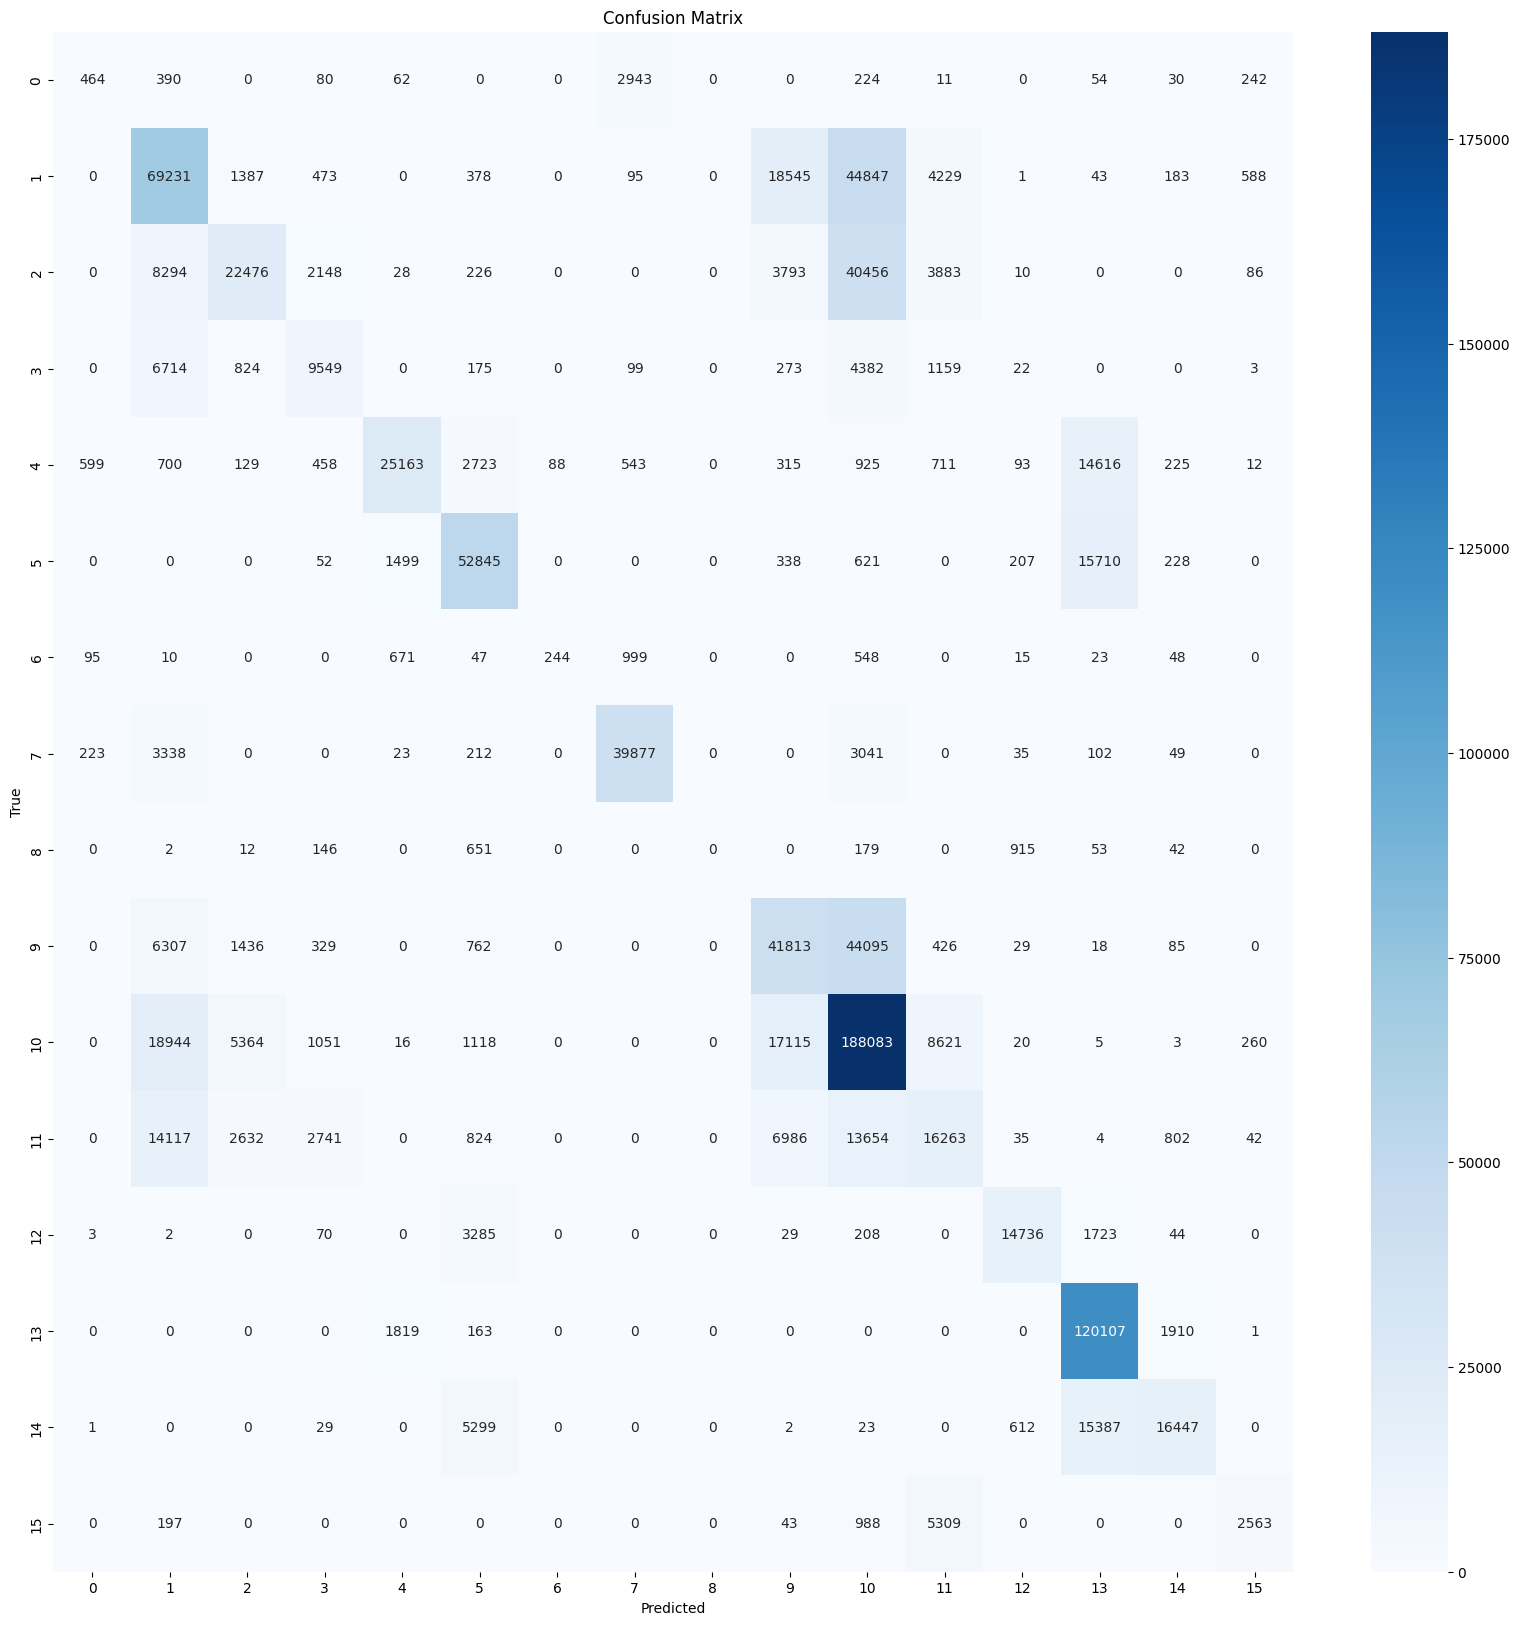

Classification Report:


/Users/huasheng/miniconda3/envs/IndianPines/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.34      0.10      0.16      4500
           1       0.54      0.49      0.52    140000
           2       0.66      0.28      0.39     81400
           3       0.56      0.41      0.47     23200
           4       0.86      0.53      0.66     47300
           5       0.77      0.74      0.75     71500
           6       0.73      0.09      0.16      2700
           7       0.89      0.85      0.87     46900
           8       0.00      0.00      0.00      2000
           9       0.47      0.44      0.45     95300
          10       0.55      0.78      0.65    240600
          11       0.40      0.28      0.33     58100
          12       0.88      0.73      0.80     20100
          13       0.72      0.97      0.82    124000
          14       0.82      0.44      0.57     37800
          15       0.68      0.28      0.40      9100

    accuracy                           0.62   1004500
   macro avg       0.62   

/Users/huasheng/miniconda3/envs/IndianPines/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/huasheng/miniconda3/envs/IndianPines/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [133]:
num_epochs = 100

# 将节点特征调整为 CNN 输入的形状
cnn_x = node_features.unsqueeze(2).unsqueeze(3).to(device)  # 形状：[num_nodes, in_channels, 1, 1]

all_preds = []
all_labels = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(cnn_x, graph_data)  # 输出形状：[num_nodes, num_classes]

    # 只计算训练集上的损失
    loss = criterion(outputs[train_mask], masked_labels[train_mask].to(device))
    #loss = criterion(outputs[train_mask], all_labels[train_mask].to(device))
    loss.backward()
    optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

    # 验证
    model.eval()
    with torch.no_grad():
        outputs = model(cnn_x, graph_data)
        _, predicted = torch.max(outputs[test_mask], 1)
        total = test_mask.sum().item()
        correct = (predicted.cpu() == masked_labels[test_mask]).sum().item()
        accuracy = 100 * correct / total
        print('Test Accuracy: {:.2f}%'.format(accuracy))
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(masked_labels[test_mask].cpu().numpy())

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# 可视化混淆矩阵
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 打印分类报告
print("Classification Report:")
print(classification_report(all_labels, all_preds))